In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial import distance
from heapq import nsmallest
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
import random
import tensorflow as tf
import tensorflow_hub as hub
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

In [2]:
classification = pd.read_csv('dataset/classification_data_newyork', delimiter=',', header=None)
classification_data = classification.iloc[:,:].values

In [3]:
doc2vec_model = Doc2Vec.load('pre_trained_models/doc2vec.bin')

In [4]:
USE_url = "https://tfhub.dev/google/universal-sentence-encoder/2"
USE_model = hub.Module(USE_url)

In [5]:
true_label = []

for i in classification_data:
    
    true_label.append(i[4])

In [6]:
articles_title_doc2vec = []

for articles in tqdm(classification_data):
    
    article_title = str(articles[0])
    article_content = str(articles[1])
    catch = article_title+" "+article_content
    
    vector_words = tknzr.tokenize(catch[:300])
    
    article_embedding = doc2vec_model.infer_vector(vector_words)

    articles_title_doc2vec.append(article_embedding)

100%|██████████| 258/258 [00:01<00:00, 141.87it/s]


In [7]:
tables_title_doc2vec = []

for tables in tqdm(classification_data):
    
    table_title = str(tables[2])
    table_content = str(tables[3])
    catch = table_title+" "+table_content
    
    vector_words = tknzr.tokenize(catch[:300])
    
    table_embedding = doc2vec_model.infer_vector(vector_words)
    
    tables_title_doc2vec.append(table_embedding)

100%|██████████| 258/258 [00:01<00:00, 172.10it/s]


#USE

In [8]:
articles_title = []

for articles in tqdm(classification_data):
    
    article_title = str(articles[0])
    article_content = str(articles[1])
    catch = article_title+" "+article_content
    
    articles_title.append(catch[:300])

100%|██████████| 258/258 [00:00<00:00, 121902.72it/s]


In [9]:
with tf.Session() as sess:
    
    sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
            
    embedding_articles = sess.run(USE_model(articles_title))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [10]:
articles_title_USE = []

for current_embedding in embedding_articles:
    
    articles_title_USE.append(current_embedding)

In [11]:
tables_title = []

for tables in tqdm(classification_data):
    
    table_title = str(tables[2])
    table_content = str(tables[3])
    catch = table_title+" "+table_content
    
    tables_title.append(catch[:300])

100%|██████████| 258/258 [00:00<00:00, 227816.93it/s]


In [12]:
with tf.Session() as sess:
    
    sess.run([tf.global_variables_initializer(), tf.tables_initializer()])
            
    embedding_tables = sess.run(USE_model(tables_title))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [13]:
tables_title_USE = []

for current_embedding in embedding_tables:
    
    tables_title_USE.append(current_embedding)

#TF-IDF

In [14]:
corpus_article_title = []

for articles in tqdm(classification_data):
    
    article_title = str(articles[0])
    article_content = str(articles[1])
    catch = article_title+" "+article_content
    
    corpus_article_title.append(catch[:300])

100%|██████████| 258/258 [00:00<00:00, 67038.19it/s]


In [15]:
vectorizer = TfidfVectorizer(stop_words='english', analyzer='word')

In [16]:
articles_title_TFIDF = vectorizer.fit_transform(corpus_article_title)
articles_title_TFIDF = articles_title_TFIDF.toarray()

In [17]:
articles_title_TFIDF.shape

(258, 4068)

In [18]:
corpus_table_title = []

for tables in tqdm(classification_data):
    
    table_title = str(tables[2])
    table_content = str(tables[3])
    catch = table_title+" "+table_content
    
    corpus_table_title.append(catch[:300])

100%|██████████| 258/258 [00:00<00:00, 125420.77it/s]


In [19]:
tables_title_TFIDF = vectorizer.transform(corpus_table_title)
tables_title_TFIDF = tables_title_TFIDF.toarray()

In [20]:
tables_title_TFIDF.shape

(258, 4068)

In [21]:
predict_class_doc2vec = []
predict_prob_doc2vec = []

for i in range(258):
    
    distance_doc2vec = cosine_similarity([articles_title_doc2vec[i]], [tables_title_doc2vec[i]])
    
    predict_prob_doc2vec.append(distance_doc2vec[0][0])
    
    if distance_doc2vec[0][0] >= 0.5:
    
        predict_class_doc2vec.append(1)
        
    else:
        
        predict_class_doc2vec.append(0)

In [22]:
predict_class_USE = []
predict_prob_USE = []

for i in range(258):
    
    distance_USE = cosine_similarity([articles_title_USE[i]], [tables_title_USE[i]])
    
    predict_prob_USE.append(distance_USE[0][0])
    
    if distance_USE[0][0] >= 0.5:
    
        predict_class_USE.append(1)
        
    else:
        
        predict_class_USE.append(0)

In [23]:
predict_class_TFIDF = []
predict_prob_TFIDF = []

for i in range(258):
    
    distance_TFIDF = cosine_similarity([articles_title_TFIDF[i]], [tables_title_TFIDF[i]])
    
    predict_prob_TFIDF.append(distance_TFIDF[0][0])
    
    if distance_TFIDF[0][0] >= 0.5:
    
        predict_class_TFIDF.append(1)
        
    else:
        
        predict_class_TFIDF.append(0)

In [24]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

y_true = true_label
y_probas_doc2vec = predict_prob_doc2vec
fpr_doc2vec, tpr_doc2vec, thresholds_doc2vec = metrics.roc_curve(y_true, y_probas_doc2vec, pos_label=1)


y_probas_USE = predict_prob_USE
fpr_USE, tpr_USE, thresholds_USE = metrics.roc_curve(y_true, y_probas_USE, pos_label=1)

y_probas_TFIDF = predict_prob_TFIDF
fpr_TFIDF, tpr_TFIDF, thresholds_TFIDF = metrics.roc_curve(y_true, y_probas_TFIDF, pos_label=1)



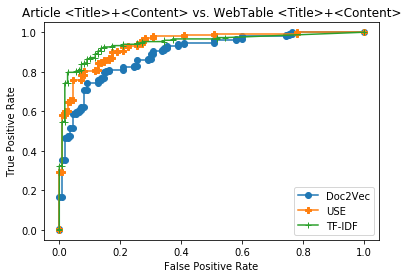

In [26]:
# Print ROC curve
plt.plot(fpr_doc2vec,tpr_doc2vec, label='Doc2Vec', marker='o')
plt.plot(fpr_USE,tpr_USE, label='USE', marker='P')
plt.plot(fpr_TFIDF,tpr_TFIDF, label='TF-IDF', marker='+')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Article <Title>+<Content> vs. WebTable <Title>+<Content>')
plt.legend()
plt.savefig('curve_ROC_catch.pdf')
plt.show() 

In [ ]:
# Print AUC
auc = np.trapz(tpr_doc2vec,fpr_doc2vec)
print('AUC:', auc)

In [ ]:
# Print AUC
auc = np.trapz(tpr_USE,fpr_USE)
print('AUC:', auc)